# Montgomery County Collision Analysis

## Introduction
<br>We will be examining traffic collisions that occurred in Montgomery County, Maryland. Our data set has over fifteen thousand collision reports based on preliminary data. The data set includes columns such as the time of day that the crash occurred, the vehicle's impact locations, and the vehicle's movement at the time of the collision. We will be using this data to see what aspects of a crash lead to lower or higher rates of injury severity. Therefore, we are most interested in the correlation of 'Injury Severity', 'Vehicle Body Type', and 'Vehicle Movement' and others. We will create new columns based on factors that are most apparent to our exploration of the data.

In [16]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [17]:
df_county = pd.read_csv('./data/Crash_Reporting_-_Drivers_Data.csv')
df_state = pd.read_csv('./data/Maryland_Statewide_Vehicle_Crashes.csv')
df_nonmotor = pd.read_csv('./data/Crash_Reporting_-_Non-Motorists_Data.csv')

In [18]:
df_county.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,DD5620004G,190046109,Rockville Police Departme,Property Damage Crash,09/26/2019 07:20:00 AM,NaN,NaN,NaN,NaN,PARKING LOT,...,15,No,No,2017,THOMAS,BUS,NO MISUSE,39.103518,-77.157669,"(39.10351817, -77.15766933)"
1,MCP29620057,200023865,Montgomery County Police,Property Damage Crash,06/18/2020 02:00:00 AM,County,DAIRYMAID DR,County,METZ DR,NaN,...,35,No,No,2020,UNK,UNK,UNKNOWN,39.154847,-77.271245,"(39.15484667, -77.271245)"
2,MCP2651004P,210035267,Montgomery County Police,Property Damage Crash,09/08/2021 12:30:00 PM,NaN,NaN,NaN,NaN,PARKING LOT OF 10109 COLESVILLE RD,...,0,No,No,2010,TOYOTA,SUV,UNKNOWN,39.020303,-77.011436,"(39.02030267, -77.01143583)"
3,MCP3050004K,200016465,Montgomery County Police,Property Damage Crash,04/19/2020 03:39:00 PM,County,RUSSETT RD,County,ARCTIC AVE,NaN,...,25,No,No,2004,DODGE,GRAND CARAVAN,NO MISUSE,39.080062,-77.097845,"(39.08006167, -77.097845)"
4,MCP2641001J,200016526,Montgomery County Police,Injury Crash,04/20/2020 09:15:00 AM,County,ARCHDALE RD,County,GUNNERS BRANCH RD,NaN,...,25,No,No,2006,HONDA,CR-V,UNKNOWN,39.175230,-77.241090,"(39.17523, -77.24109)"


In [4]:
df_county['Weather'].value_counts()

CLEAR                       106202
RAINING                      19026
CLOUDY                       16044
SNOW                          1432
UNKNOWN                        627
FOGGY                          623
WINTRY MIX                     388
OTHER                          346
SLEET                          213
SEVERE WINDS                   153
BLOWING SNOW                   115
BLOWING SAND, SOIL, DIRT        15
Name: Weather, dtype: int64

In [19]:
df_state.head()

,YEAR,QUARTER,LIGHT_DESC,LIGHT_CODE,COUNTY_DESC,COUNTY_NO,MUNI_DESC,MUNI_CODE,JUNCTION_DESC,JUNCTION_CODE,...,FEET_MILES_FLAG_DESC,FEET_MILES_FLAG,DISTANCE_DIR_FLAG,REFERENCE_NO,REFERENCE_TYPE_CODE,REFERENCE_SUFFIX,REFERENCE_ROAD_NAME,LATITUDE,LONGITUDE,LOCATION
0,2020,Q2,Daylight,1.00,Baltimore,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.277263,-76.503693,POINT (-76.5036932 39.27726285)
1,2022,Q2,Dark Lights On,3.00,Montgomery,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.992209,-77.097021,POINT (-77.097020666667 38.9922095)
2,2020,Q4,NaN,6.02,Baltimore,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.323620,-76.503080,POINT (-76.503080116667 39.323620083333)
3,2022,Q1,Daylight,1.00,Baltimore,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.411213,-76.628028,POINT (-76.628028425147 39.411213105087)
4,2022,Q2,Dark Lights On,3.00,Queen Anne's,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.974880,-76.281090,POINT (-76.28109 38.97488)


In [20]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   878343 non-null  int64  
 1   QUARTER                878343 non-null  object 
 2   LIGHT_DESC             841025 non-null  object 
 3   LIGHT_CODE             878343 non-null  float64
 4   COUNTY_DESC            878329 non-null  object 
 5   COUNTY_NO              878329 non-null  float64
 6   MUNI_DESC              0 non-null       float64
 7   MUNI_CODE              659957 non-null  float64
 8   JUNCTION_DESC          760119 non-null  object 
 9   JUNCTION_CODE          791512 non-null  float64
 10  COLLISION_TYPE_DESC    878343 non-null  object 
 11  COLLISION_TYPE_CODE    878343 non-null  int64  
 12  SURF_COND_DESC         789107 non-null  object 
 13  SURF_COND_CODE         791512 non-null  float64
 14  LANE_CODE              668083 non-nu

In [21]:
df_state["WEATHER_DESC"].unique()

array(['Not Applicable', nan, 'Raining', 'Other', 'Clear', 'Cloudy',
       'Unknown', 'Wintry Mix', 'Foggy', 'Severe Winds', 'Snow',
       'Blowing Snow', 'Blowing Sand, Soil, Dirt', 'Sleet'], dtype=object)

In [22]:
df_state["WEATHER_DESC"].value_counts()

Clear                       197604
Raining                     111589
Not Applicable               85294
Cloudy                       28823
Unknown                       8343
Foggy                         4847
Snow                          4661
Wintry Mix                    3740
Other                         2254
Severe Winds                  1348
Blowing Snow                   994
Sleet                          941
Blowing Sand, Soil, Dirt        39
Name: WEATHER_DESC, dtype: int64

## Data Cleaning

In [23]:
# Merge the two dataframes with the values that do not already exist in the county data
df_county = pd.merge(left=df_county, right=df_nonmotor[~df_nonmotor['Report Number'].isin(df_county['Report Number'])], on='Report Number', how='left')
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157554 entries, 0 to 157553
Data columns (total 74 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Report Number                     157554 non-null  object 
 1   Local Case Number_x               157554 non-null  object 
 2   Agency Name_x                     157554 non-null  object 
 3   ACRS Report Type_x                157554 non-null  object 
 4   Crash Date/Time_x                 157554 non-null  object 
 5   Route Type_x                      142110 non-null  object 
 6   Road Name_x                       142960 non-null  object 
 7   Cross-Street Type_x               142086 non-null  object 
 8   Cross-Street Name_x               142954 non-null  object 
 9   Off-Road Description_x            14592 non-null   object 
 10  Municipality_x                    17502 non-null   object 
 11  Related Non-Motorist_x            4958 non-null    o

In [24]:
#Merges unwanted columns in Weather_x of County Data
df_county['Weather_x'] = df_county['Weather_x'].replace(
    {"BLOWING SAND, SOIL, DIRT": "OTHER", 
     "WINTRY MIX": "OTHER" , "BLOWING SNOW": "OTHER", "UNKNOWN": "OTHER"})
df_county['Weather_x'].value_counts()

CLEAR           106202
RAINING          19026
CLOUDY           16044
OTHER             1491
SNOW              1432
FOGGY              623
SLEET              213
SEVERE WINDS       153
Name: Weather_x, dtype: int64

In [25]:
#Merges unwanted columns in WEATHER_DESC of State Data
df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].dropna(how='any')
df_state['WEATHER_DESC'] = df_state['WEATHER_DESC'].replace(
    {"Blowing Sand, Soil, Dirt": "Other", 
     "Wintry Mix": "Other" , "Blowing Snow": "Other", "Unknown": "Other"})
df_state['WEATHER_DESC'].value_counts()
#Clear, Raining, Cloudy, Other, snow, Foggy, Sleet, Severe Winds

Clear             197604
Raining           111589
Not Applicable     85294
Cloudy             28823
Other              15370
Foggy               4847
Snow                4661
Severe Winds        1348
Sleet                941
Name: WEATHER_DESC, dtype: int64

## Montgomery County Visualizations

Text(0.5, 1.0, '# of Reported Collisions by Weather Type in Montgomery County')

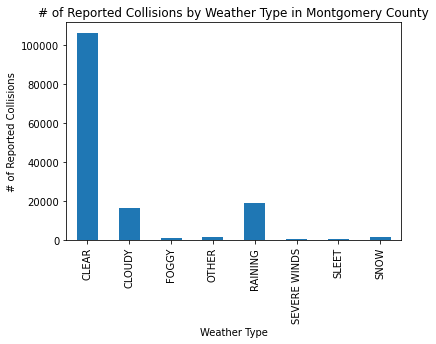

In [26]:
#Graph 1: Raw Counts of Reported Accidents by Weather Type
df_county_weather = df_county[df_county['Weather_x'].notna()]
weatherGroups = df_county_weather.groupby("Weather_x")
weather_Reports = weatherGroups['Report Number'].count()

chart1 = weather_Reports.plot(kind="bar", title="Accidents by Weather Type")
chart1.set_xlabel("Weather Type")
chart1.set_ylabel("# of Reported Collisions")
chart1.set_title("# of Reported Collisions by Weather Type in Montgomery County")

Text(0.5, 1.0, '# of Reported Collisions by Weather Type in Montgomery County (Log)')

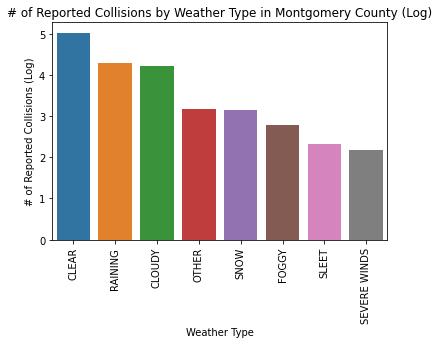

In [28]:
#Log Version of graph1
x1 = df_county['Weather_x'].value_counts().index
y1 = np.log10(df_county['Weather_x'].value_counts().values)
chart = sns.barplot(x=x1,y=y1)
plt.xticks(rotation=90)
plt.xlabel("Weather Type")
plt.ylabel("# of Reported Collisions (Log)")
plt.title("# of Reported Collisions by Weather Type in Montgomery County (Log)")

Text(0.5, 1.0, '# of Reported Collisions by Speed Limit')

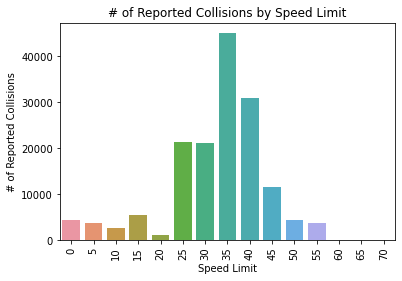

In [41]:
#Number of Collisions by Speed Limit Graph
x3 = df_county["Speed Limit"].value_counts().index
y3 = df_county["Speed Limit"].value_counts().values
chart = sns.barplot(x=x3,y=y3)
plt.xticks(rotation=90)
plt.xlabel("Speed Limit")
plt.ylabel("# of Reported Collisions")
plt.title("# of Reported Collisions by Speed Limit")

In [ ]:
#Simple Vehicle Body Type vs. # of Accidents
df_county['Simple Vehicle Body Type'].value_counts().plot.bar()
plt.xlabel("Vehicle Body Type")
plt.ylabel("# of Reported Accidents")
plt.title("# of Reported Accidents per Vehicle Body Type")

Text(0.5, 1.0, '# of Reported Accidents per Vehicle Body Type')

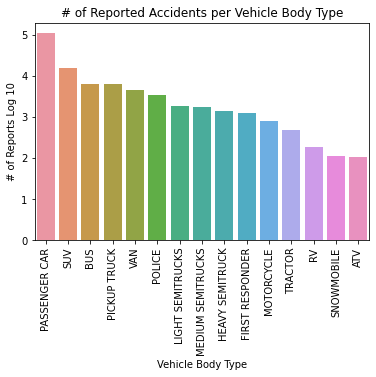

In [15]:
#Log Version of Simple Vehicle Body Type vs. # of Accidents
df_county['Simple Vehicle Body Type'] = df_county['Vehicle Body Type'].replace({'TRANSIT BUS':"BUS", "SCHOOL BUS": "BUS", "(SPORT) UTILITY VEHICLE": "SUV", "OTHER LIGHT TRUCKS (10,000LBS (4,536KG) OR LESS)": "LIGHT SEMITRUCKS", "CARGO VAN/LIGHT TRUCK 2 AXLES (OVER 10,000LBS (4,536 KG))": "MEDIUM SEMITRUCKS", "POLICE VEHICLE/NON EMERGENCY": "POLICE", "POLICE VEHICLE/EMERGENCY":"POLICE", "MEDIUM/HEAVY TRUCKS 3 AXLES (OVER 10,000LBS (4,536KG))":"HEAVY SEMITRUCK", "STATION WAGON":"SUV", "TRUCK TRACTOR":"TRACTOR", "AMBULANCE/EMERGENCY":"FIRST RESPONDER", "FIRE VEHICLE/EMERGENCY":"FIRST RESPONDER","OTHER BUS":"BUS","FIRE VEHICLE/NON EMERGENCY":"FIRST RESPONDER", "RECREATIONAL VEHICLE":"RV", "AMBULANCE/NON EMERGENCY":'FIRST RESPONDER', 'ALL TERRAIN VEHICLE (ATV)':"ATV"})
# df_county['Simple Vehicle Body Type'] = df_county['Simple Vehicle Body Type'].drop(axis='columns', ['MOPED', 'AUTOCYCLE', 'LOW SPEED VEHICLE', 'CROSS COUNTRY BUS', 'FARM VEHICLE', 'LIMOUSINE'])
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'MOPED']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'AUTOCYCLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LOW SPEED VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'CROSS COUNTRY BUS']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'FARM VEHICLE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'LIMOUSINE']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'UNKNOWN']
df_county = df_county[ df_county['Simple Vehicle Body Type'] != 'OTHER']
x = df_county['Simple Vehicle Body Type'].value_counts().index
y = np.log10(df_county['Simple Vehicle Body Type'].value_counts().values)
sns.barplot(x=x,y=y)
plt.xticks(rotation=90)
plt.xlabel("Vehicle Body Type")
plt.ylabel("# of Reports Log 10")
plt.title("# of Reported Accidents per Vehicle Body Type")

# Maryland State Visualizations

Text(0.5, 1.0, '# of Reported Collisions by Weather Type')

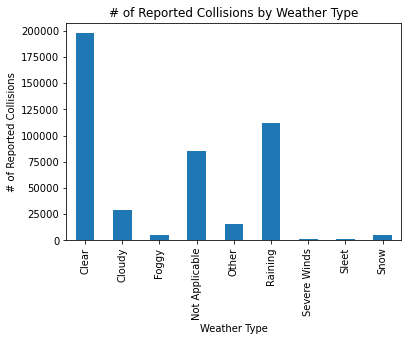

In [31]:
#Graph 2: Raw Counts of Reported Accidents by Weather Type (Maryland State Data)
df_state_weather = df_state[df_state['WEATHER_DESC'].notna()]
stateWeather = df_state_weather.groupby("WEATHER_DESC")
stateWeather_Reports = stateWeather['REPORT_NO'].count()

chart1 = stateWeather_Reports.plot(kind="bar", title="Accidents by Weather Type")
chart1.set_xlabel("Weather Type")
chart1.set_ylabel("# of Reported Collisions")
chart1.set_title("# of Reported Collisions by Weather Type in Maryland")

Text(0.5, 1.0, '# of Reported Collisions by Weather Type (Log)')

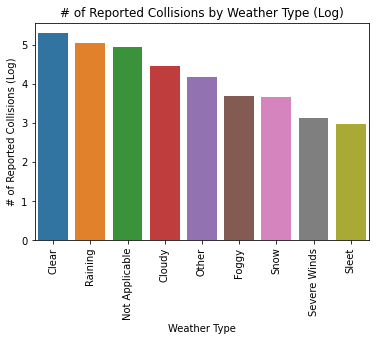

In [29]:
#Log Version of Graph 2
x2 = df_state['WEATHER_DESC'].value_counts().index
y2 = np.log10(df_state['WEATHER_DESC'].value_counts().values)
chart = sns.barplot(x=x2,y=y2)
plt.xticks(rotation=90)
plt.xlabel("Weather Type")
plt.ylabel("# of Reported Collisions (Log)")
plt.title("# of Reported Collisions by Weather Type in Maryland (Log)")

## Conclusion